In [1]:
import numpy as np
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdMolTransforms

In [2]:
wb = load_workbook('molecular_glues.xlsx')['Sheet1']
data = []
for row in wb.iter_rows(values_only=True):
    data.append(row)
data.pop(0)

smiles_list = [d[0] for d in data]
mols = [Chem.MolFromSmiles(s) for s in smiles_list]

In [3]:
# scaff2 = Chem.MolFromSmiles('O=C1C(C)(N2C(=O)c3c(C2=O)cccc3)CCC(=O)N1')
# scaff2_temp = Chem.MolFromSmiles('O=C1C(N2C(=O)c3c(C2=O)cccc3)CCC(=O)N1')
scaff2_changed = Chem.MolFromSmiles('O=C1CCC(N2C(=O)c3ccccc3C2=O)C(=O)N1')

# scaff1 = Chem.MolFromSmiles('O=C1C(C)(N2C(=O)c3c(cccc3)C2)CCC(=O)N1')
# scaff1_temp = Chem.MolFromSmiles('O=C1C(N2C(=O)c3c(cccc3)C2)CCC(=O)N1')
scaff1_changed = Chem.MolFromSmiles('O=C1CCC(N2Cc3ccccc3C2=O)C(=O)N1')

mol1 = Chem.MolFromSmiles('O=CNC=O')
ring = Chem.MolFromSmiles('O=C1CCCC(=O)N1')

In [4]:
def view_smile(mol):
    if isinstance(mol, str):
        mol = Chem.MolFromSmiles(mol)
    img = Draw.MolToImage(mol, legend='Labeled Carbons')
    return img

In [5]:
def categorize_mols(mols):
    scaff1_list = []
    scaff2_list = []
    rings = []
    others = []
    
    for mol in mols:
        # Match with scaffold2
        matches = mol.GetSubstructMatches(scaff2_changed)
        if len(matches) > 0:
            scaff2_list.append(mol)
            continue
        # Match with scaffold1
        matches = mol.GetSubstructMatches(scaff1_changed)
        if len(matches) > 0:
            scaff1_list.append(mol)
            continue
        # Match with CNC
        matches = mol.GetSubstructMatches(ring)
        if len(matches) > 0:
            rings.append(mol)
            continue
        others.append(mol)
        continue
        
    return [scaff2_list, scaff1_list, rings, others]

In [6]:
scaff2_list, scaff1_list, rings, others = categorize_mols(mols)
# Glutermide
if len(others) > 0:
    raise Exception("No matches found")

In [7]:
len(rings)

645

In [11]:
def find_sidechain_lengths(mol):
    # Match with scaffold2
    if isinstance(mol, str):
        mol = Chem.MolFromSmiles(mol)
    
    matches = mol.GetSubstructMatches(scaff2_changed)
    if len(matches) > 0:
        # Scaff2: 9, 10, 11, 12
        startInd = [matches[0][9], matches[0][10], matches[0][11], matches[0][12]]
        ringInd = [matches[0][8], matches[0][9], matches[0][10], matches[0][11], matches[0][12], matches[0][13]]
        # Remove lines below if do not want to label atoms
        mol.GetAtomWithIdx(matches[0][9]).SetProp("atomLabel", "R0")
        mol.GetAtomWithIdx(matches[0][10]).SetProp("atomLabel", "R1")
        mol.GetAtomWithIdx(matches[0][11]).SetProp("atomLabel", "R2")
        mol.GetAtomWithIdx(matches[0][12]).SetProp("atomLabel", "R3")
        return chain_length(mol, startInd, ringInd)

    # Match with scaffold1
    matches = mol.GetSubstructMatches(scaff1_changed)
    if len(matches) > 0:
        # Scaff1: 8, 9, 10, 11
        startInd = [matches[0][8], matches[0][9], matches[0][10], matches[0][11]]
        ringInd = [matches[0][7], matches[0][8], matches[0][9], matches[0][10], matches[0][11], matches[0][12]]
        mol.GetAtomWithIdx(matches[0][8]).SetProp("atomLabel", "R0")
        mol.GetAtomWithIdx(matches[0][9]).SetProp("atomLabel", "R1")
        mol.GetAtomWithIdx(matches[0][10]).SetProp("atomLabel", "R2")
        mol.GetAtomWithIdx(matches[0][11]).SetProp("atomLabel", "R3")
        return chain_length(mol, startInd, ringInd)

    # Match with CNC
    matches = mol.GetSubstructMatches(ring)
    if len(matches) > 0:
        # rings: 2, 3, 4
        startInd = [2, 3, 4]
        ringInd = [1, 2, 3, 4, 5]
        
        startInd = [matches[0][2], matches[0][3], matches[0][4]]
        ringInd = [matches[0][1], matches[0][2], matches[0][3], matches[0][4], matches[0][5]]
        mol.GetAtomWithIdx(matches[0][2]).SetProp("atomLabel", "R0")
        mol.GetAtomWithIdx(matches[0][3]).SetProp("atomLabel", "R1")
        mol.GetAtomWithIdx(matches[0][4]).SetProp("atomLabel", "R2")
        return chain_length(mol, startInd, ringInd)
    
    raise Exception("No matches found")
    return

In [12]:
def chain_length(mol, start_atom_idx, ring_idx):
    # Add H
    mol = Chem.AddHs(mol)
    
    # Optimize the geometry
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)

    # Get the 3D coordinates
    conf = mol.GetConformer()

    visited = set()

    def dfs(atom_idx, length):
        visited.add(atom_idx)
        max_length = length

        for bond in mol.GetAtomWithIdx(atom_idx).GetBonds():
            neighbor_idx = bond.GetOtherAtomIdx(atom_idx)
            if neighbor_idx in ring_idx:
                continue
            if neighbor_idx not in visited:
                bond_length = rdMolTransforms.GetBondLength(conf, atom_idx, neighbor_idx)
                new_length = length + bond_length
                max_length = max(max_length, dfs(neighbor_idx, new_length))

        return max_length

    out = []
    for i in start_atom_idx:
        visited = set()
        total_length = dfs(i, 0.0)
        out.append(total_length)
    return out

[13.891285185406346, 1.1117923558784506, 1.1114370916473952]


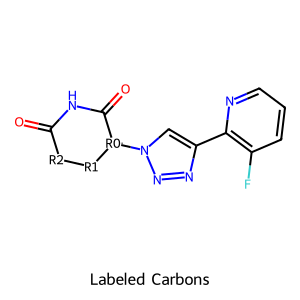

In [13]:
tempMol = rings[5]
print(find_sidechain_lengths(tempMol))
view_smile(tempMol)